In [1]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import numpyro
import numpyro.distributions as dist
import pandas as pd
import scipy.stats as stats
import seaborn as sns
from numpyro import handlers
from numpyro.infer.reparam import TransformReparam

numpyro.set_host_device_count(4)

In [2]:
# let's just have one feature influence the target

n_samples = 112
hours_worked = stats.norm(loc=0, scale=1).rvs(n_samples) + 5
answer_unconstrained = 1 - hours_worked + stats.norm(loc=0, scale=0.1).rvs(n_samples)
answer = np.where(
    answer_unconstrained < -5, 0, np.where(answer_unconstrained < -2.5, 1, 2)
)

hours_sc = (hours_worked - np.mean(hours_worked))/np.std(hours_worked)

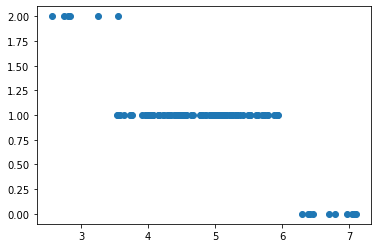

In [3]:
plt.plot(hours_worked, answer, "o");

In [4]:
def categorical_regression(hours_worked, n_answers, answer=None):
    alpha_hours_worked = numpyro.sample(
        "alpha_hours_worked",
        dist.Normal(0, 10),
    )
    beta_hours_worked = numpyro.sample(
        "beta_hours_worked",
        dist.Normal(0, 1).expand([n_answers - 1]),
    )
    logits = alpha_hours_worked + jnp.outer(hours_worked, beta_hours_worked)
    logits_padded = numpyro.deterministic(
        "logits_padded", jnp.hstack([logits, jnp.zeros((len(hours_worked), 1))])
    )
    assert logits_padded.shape == (n_samples, n_answers)

    numpyro.sample(
        "answer",
        dist.Categorical(logits=logits_padded),
        obs=answer,
    )

In [5]:
predictive = numpyro.infer.Predictive(categorical_regression, num_samples=100)
predictions = predictive(
    jax.random.PRNGKey(0), hours_worked=hours_sc, n_answers=len(np.unique(answer))
)

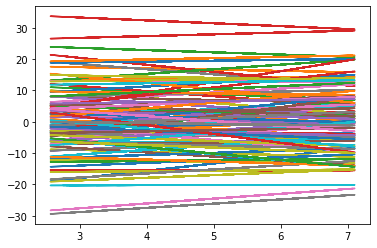

In [6]:
fig, ax = plt.subplots()

ax.plot(hours_worked, predictions['logits_padded'][:, :, 0].T);

In [7]:
sampler = numpyro.infer.NUTS(categorical_regression)
mcmc = numpyro.infer.MCMC(
    sampler,
    num_chains=1,
    num_samples=1000,
    num_warmup=1000,
)

mcmc.run(
    jax.random.PRNGKey(0),
    n_answers=len(np.unique(answer)),
    hours_worked=hours_sc,
    answer=answer,
)

sample: 100%|█| 2000/2000 [00:03<00:00, 613.57it/s, 7 steps of size 2.70e-01. ac


In [8]:
mcmc.print_summary()


                          mean       std    median      5.0%     95.0%     n_eff     r_hat
  alpha_hours_worked      3.67      0.74      3.63      2.50      4.84    194.63      1.02
beta_hours_worked[0]      2.41      0.52      2.40      1.54      3.21    193.91      1.02
beta_hours_worked[1]      1.76      0.50      1.75      1.00      2.62    182.82      1.02

Number of divergences: 0


In [9]:
predictive = numpyro.infer.Predictive(categorical_regression, mcmc.get_samples())
predictions = predictive(
    jax.random.PRNGKey(0), hours_worked=hours_sc, n_answers=len(np.unique(answer))
)

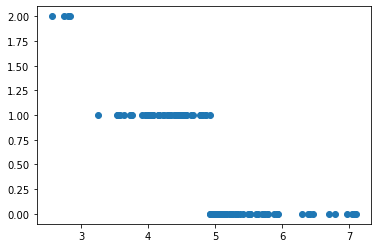

In [10]:
fig, ax = plt.subplots()

ax.plot(hours_worked, stats.mode(predictions['answer'], axis=0).mode.flatten(), 'o')

In [11]:
predictions['answer'].mean(axis=0).round(0)

DeviceArray([0., 1., 1., 0., 1., 0., 1., 1., 1., 0., 0., 0., 1., 0., 1.,
             0., 0., 1., 1., 0., 0., 1., 1., 0., 0., 0., 0., 1., 1., 0.,
             1., 0., 0., 1., 1., 0., 1., 1., 1., 1., 0., 0., 1., 1., 2.,
             1., 1., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 1., 0., 1.,
             0., 1., 1., 1., 0., 0., 0., 1., 0., 1., 1., 1., 0., 0., 1.,
             1., 0., 0., 1., 0., 1., 0., 1., 1., 0., 1., 1., 0., 1., 0.,
             1., 0., 1., 0., 1., 1., 0., 0., 1., 1., 1., 1., 1., 0., 1.,
             0., 1., 1., 1., 1., 1., 0.], dtype=float32)

In [12]:
# so maybe, we shouldn't round to the nearest integer.

# Maybe, we need cutpoints: c_0, c_1

# if pred < c_0: class 2
# if c_0 < pred <= c_1: class 1
# if c_1 <= pred: class 0

In [13]:
pred = 5.
dist.OrderedLogistic(predictor=pred, cutpoints=np.array([3, 6, 9])).sample(jax.random.PRNGKey(0), sample_shape=(100,))

DeviceArray([0, 2, 2, 1, 1, 2, 1, 1, 1, 1, 0, 0, 2, 2, 1, 2, 1, 1, 0, 1,
             1, 2, 1, 2, 1, 1, 1, 1, 2, 0, 2, 0, 1, 1, 1, 1, 1, 0, 2, 1,
             1, 1, 1, 2, 2, 2, 1, 0, 1, 2, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1,
             1, 2, 1, 2, 1, 2, 1, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 2, 0, 1,
             2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 0, 0, 1, 1, 2, 1, 1, 3, 2, 1],            dtype=int32)

In [14]:
def ordered_regression(hours_worked, n_answers, answer=None):
    alpha_hours_worked = numpyro.sample(
        "alpha_hours_worked",
        dist.Normal(0, 10),
    )
    beta_hours_worked = numpyro.sample(
        "beta_hours_worked",
        dist.Normal(0, 1),
    )
    pred = numpyro.deterministic('pred', alpha_hours_worked + beta_hours_worked*hours_worked)
    with handlers.reparam(config={"cutpoints": TransformReparam()}):
        cutpoints = numpyro.sample(
            "cutpoints",
            dist.TransformedDistribution(
                dist.Dirichlet(np.ones(n_answers)*10.),
                dist.transforms.SimplexToOrderedTransform(anchor_point=0.),
            ),
        )
    

    numpyro.sample(
        "answer",
        dist.OrderedLogistic(predictor=pred, cutpoints=cutpoints),
        obs=answer,
    )

In [15]:
predictive = numpyro.infer.Predictive(ordered_regression, num_samples=100)
predictions = predictive(
    jax.random.PRNGKey(0), hours_worked=hours_sc, n_answers=len(np.unique(answer))
)

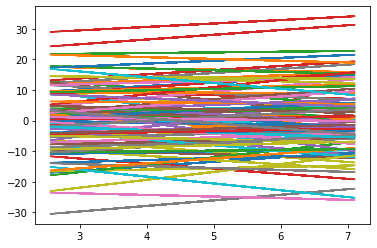

In [16]:
fig, ax = plt.subplots()

ax.plot(hours_worked, predictions['pred'].T);

In [17]:
sampler = numpyro.infer.NUTS(ordered_regression)
mcmc = numpyro.infer.MCMC(
    sampler,
    num_chains=1,
    num_samples=1000,
    num_warmup=1000,
)

mcmc.run(
    jax.random.PRNGKey(0),
    n_answers=len(np.unique(answer)),
    hours_worked=hours_sc,
    answer=answer,
)

sample: 100%|█| 2000/2000 [00:05<00:00, 393.96it/s, 15 steps of size 2.69e-01. a


In [18]:
mcmc.print_summary()


                          mean       std    median      5.0%     95.0%     n_eff     r_hat
  alpha_hours_worked     -0.16      0.58     -0.15     -1.13      0.74    357.62      1.00
   beta_hours_worked     -1.45      0.25     -1.44     -1.88     -1.06    330.25      1.00
   cutpoints_base[0]      0.09      0.05      0.08      0.02      0.17    287.42      1.00
   cutpoints_base[1]      0.82      0.04      0.83      0.76      0.89    420.11      1.00
   cutpoints_base[2]      0.09      0.04      0.08      0.02      0.15    432.78      1.00

Number of divergences: 0


In [19]:
predictive = numpyro.infer.Predictive(ordered_regression, mcmc.get_samples())
predictions = predictive(
    jax.random.PRNGKey(0), hours_worked=hours_sc, n_answers=len(np.unique(answer))
)

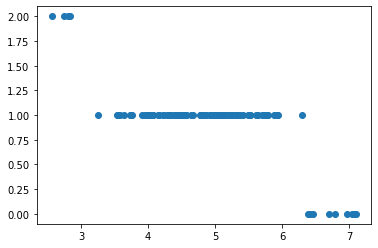

In [20]:
fig, ax = plt.subplots()

ax.plot(hours_worked, stats.mode(predictions['answer'], axis=0).mode.flatten(), 'o')

In [ ]:
# ya know, this is probably plenty of info. Let's just...make this absolutely clear
# do less, seriously. Get 1 idea out to your audience, 1 really important idea, and you'll be done.

In [21]:
# before going any further, we should clarify what a categorical distribution is.